In [ ]:
'''
Aim:
Separate the contribution of O, Ne, Mg, Si, Fe, Ni,
which are the mainly contributed elements at FeL range

Procedures:
1. Generate the ICM spectral model 
1) Generate total, later subtract continuum

Model:
vapec in xspec
He, C, N, O, Ne, Mg, Al, Si, S, Ar, Ca, Fe, Ni wrt Solar (defined by the abund command)

2. Generate photons 
(XMM response file, exposure time)

3. take median or mean energy from the photons and 
plot the median energy versus the temperature


'''

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os


In [8]:
# ## for tot spectrums
#He, C, N, O, Ne, Mg, Al, Si, S, Ar, Ca, Fe, Ni wrt Solar (defined by the abund command)
# set other elements to 0 except for target element is 0.3


ele_idx = {'O':3, 'Ne':4, 'Mg':5, 'Si':7, 'Fe':11, 'Ni':12}
# settings
INST = 'pn'
t_exp = 1e9 # sec

T_arr = np.arange(0.1, 3.1, 0.1) # keV
reds = 0.05
nH = 0
abun = 0.3
A = 299.47
norm = 1.5e-3/400/np.pi * A

workdir = '/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/'
codedir = os.chdir(f'{workdir}/bin')


f = open(f'gen_tot-indabun_mdl.sh', 'w')

f.write('''
rm ../mdls/tot-indabun*.xcm
xspec << EOT
@../sample_mdls/tot-indabun_ideal_mdl_nH_1e20_z_005_norm_1_T_1.xcm
abun aspl
''')


for T in T_arr:
    for ele in ele_idx.keys():
        switch_arr = np.zeros(13)
        switch_arr[ele_idx[ele]] = 0.3
        for i in range(13):
            f.write(f'new {i+3} {switch_arr[i]}\n')
        f.write(f'''
new 1 {nH}
new 2 {T}
new 16 {reds}
new 17 {norm}
save mo ../mdls/tot-indabun-{ele}_ideal-mdl_nH_1e20_z_005_suzakunorm_15e-4_{INST}_A{int(A)}_T_{T:.1f}_abun{abun:.1f}_nH{nH:.2f}.xcm
''')

f.write('EOT')
f.close()


In [3]:
#!/bin/bash

# Define your input filenames
exposure_time=1000000000               # Replace with your desired exposure time in seconds
output_dir="../mock_spectras"  # Replace with your desired output directory

# Create the output directory if it doesn't exist
mkdir -p "$output_dir"


# Loop through XCM files in the current directory and generate mock spectra
for inst in pn; do
resp_file="${output_dir}/${inst}.rmf"  # Replace with your XMM response file
arf_file="${output_dir}/${inst}.arf"
for head in tot-indabun; do
rm $output_dir/*$head*.fak
for xspec_model_file in ../mdls/${head}*${inst}*.xcm; do
# Extract the model name (excluding the .xcm extension) from the file
model_name="$(basename "$xspec_model_file" | sed 's/\.xcm$//')"
# Define the output spectrum filename based on the model name
output_spectrum="$output_dir/mock_spectrum_${model_name}.fak"

# Run XSpec in batch mode to generate the mock spectrum
xspec <<EOF
log >${output_spectrum}.log # no space after >!
data none               # Clear any existing data
@$xspec_model_file # Load the XCM model file
fakeit none
$resp_file  
$arf_file
n # no poisson noise
 # noheading
$output_spectrum
$exposure_time, 1, 0
log none
exit
EOF

echo "Mock spectrum for $model_name generated and saved as $output_spectrum"
done
done
done

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

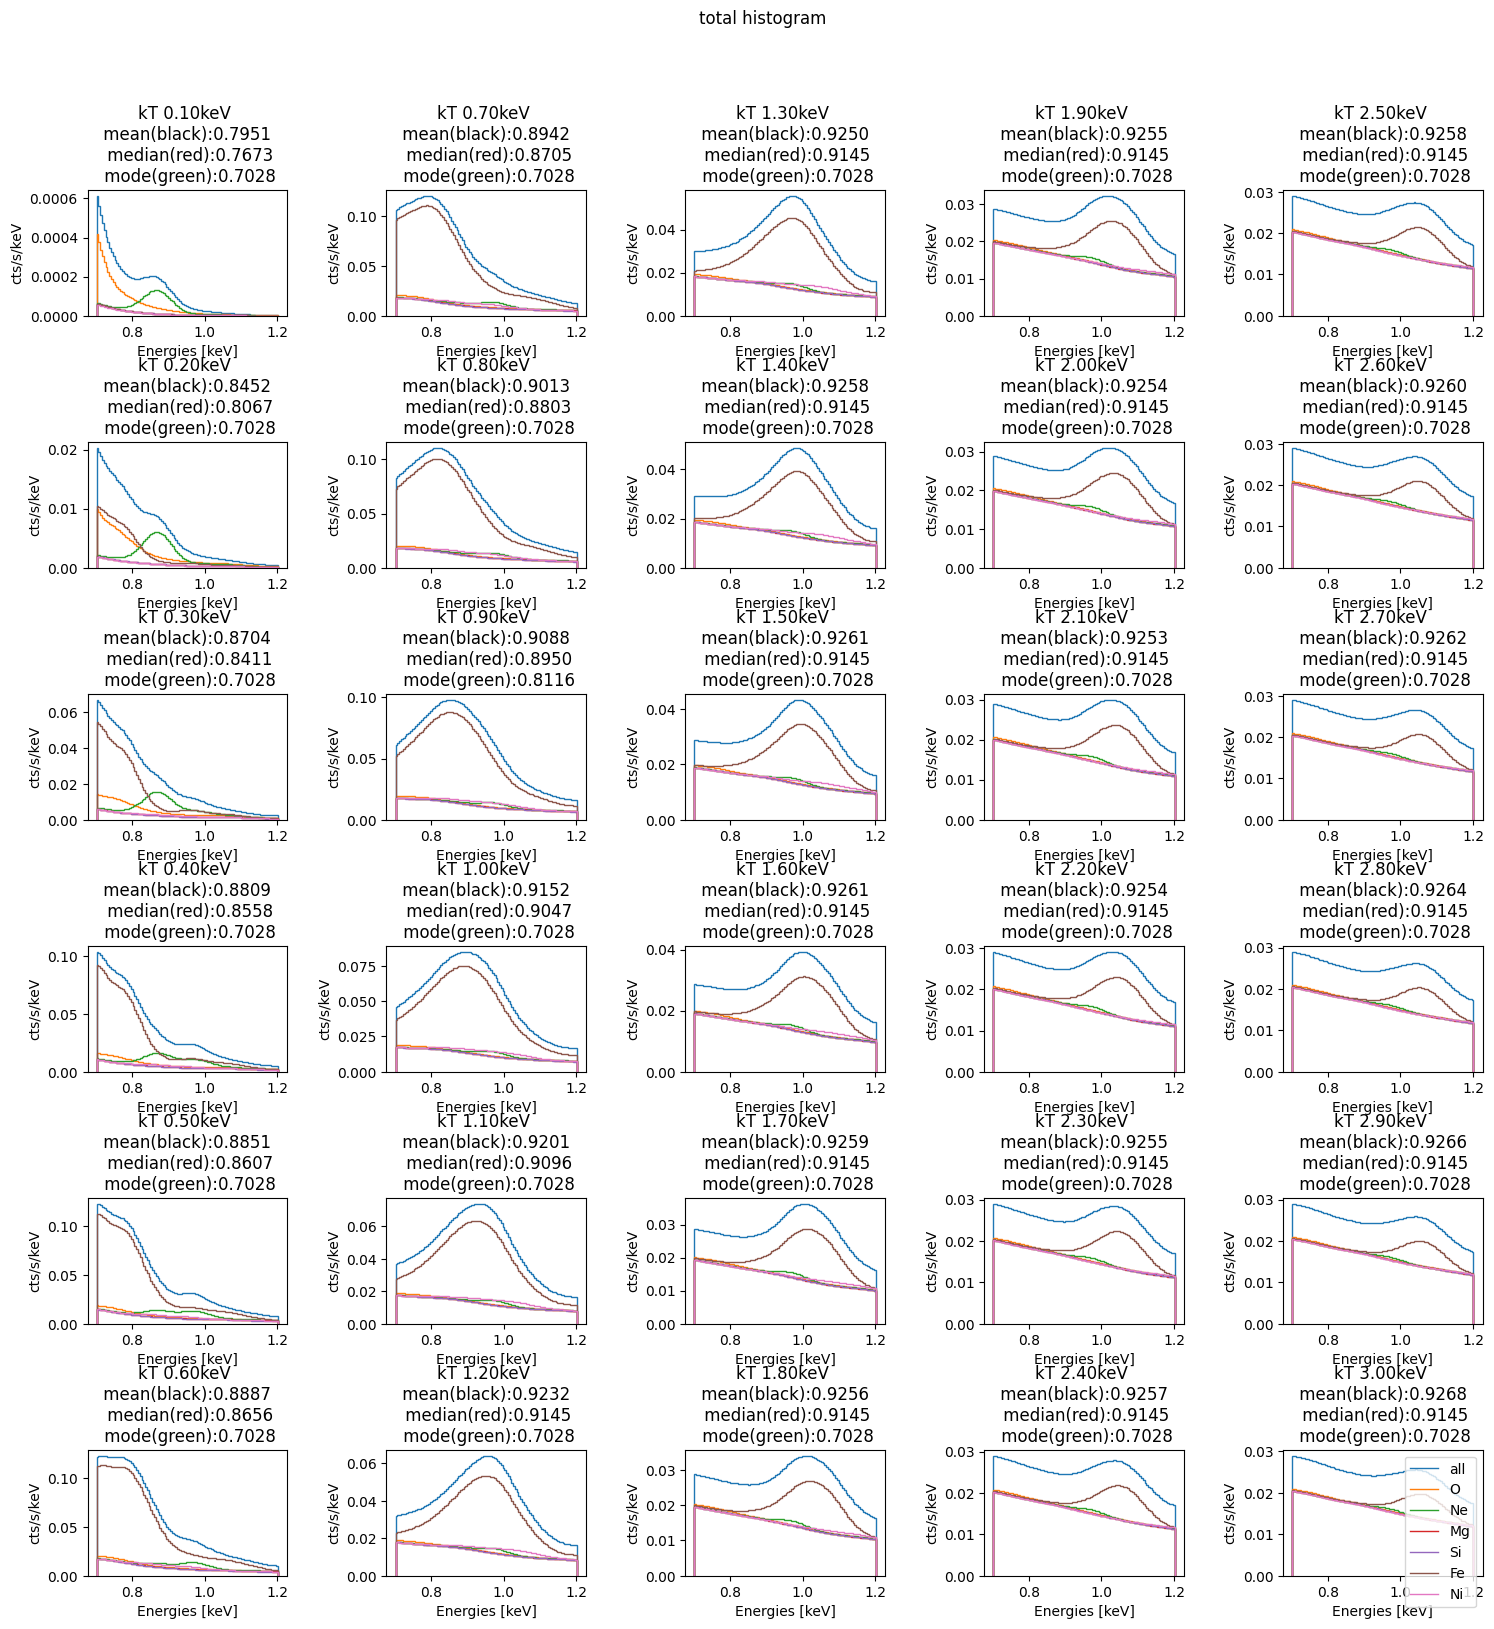

In [29]:
'''
1. load channel to energy in rmf file
2. load spectrum counts in 0.7-1.2 keV
3. cal median of the photons
'''

cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']

os.chdir(f'/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/mock_spectras')
from astropy.io import fits
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

def most_common_ele_in1darr(arr):
    u, indices, counts = np.unique(arr, return_index = True, return_counts = True)
    return u[np.argmax(counts)]

def ctr2photons_from_spec(filename, time_exp, energy_msk, energy_range):
    fak_file = fits.open(filename)
    ctr = fak_file[1].data['RATE']
    cts = np.array(ctr[energy_msk] * time_exp).astype(int)
    data_arr = np.repeat(energy_range[:-1], cts)

    return data_arr

def gen_photons_for_lines(tot_filename, cont_filename, time_exp, energy_msk, energy_range):
    tot_file = fits.open(tot_filename)
    cont_file = fits.open(cont_filename)

    tot_ctr = tot_file[1].data['RATE']
    cont_ctr = cont_file[1].data['RATE']
    ctr = tot_ctr - cont_ctr

    cts = np.array(ctr[energy_msk] * time_exp).astype(int)
    data_arr = np.repeat(energy_range, cts)

    return data_arr


T_arr = np.arange(0.1, 3.1, 0.1)
t_exp = 1000000000


for INST in ['pn']: # 'mos1', 'mos2', 'pn'

    # load and filter the energy range
    rmf_file = fits.open(f'{INST}.rmf')
    Elo = rmf_file[2].data['E_MIN']
    Ehi = rmf_file[2].data['E_MAX']

    # filter ctr in 0.7-1.2 keV
    E_msk = (Elo>0.7) & (Elo<1.2)
    E_range = np.append(Elo[E_msk], Ehi[E_msk][-1])

    # make the plot
    # fig = plt.subplots()
    fig, axs = plt.subplots(6,5, figsize = (18,18), gridspec_kw={'wspace': 0.5, 'hspace': 1.0})

    # initialize  
    result_dict ={}
    for type in ['tot']:
        result_dict[type] = {}
        for stat in ['med', 'mean', 'sum', 'mode']:
            result_dict[type][stat] = np.zeros(T_arr.shape)

    for i, T in enumerate(T_arr):
        for k, ele in enumerate(['all', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'Ni']):
            if ele == 'all':
                tot_filename = glob(f'mock*tot_ideal*{INST}*T_{T:.1f}*abun*.fak')[0]
            else:
                tot_filename = glob(f'mock*tot-indabun*{ele}*{INST}*T_{T:.1f}*abun*.fak')[0]
            
            cts_dir = {}
            cts_dir['tot'] = ctr2photons_from_spec(tot_filename, t_exp, E_msk, E_range)

            for type in ['tot']:
                result_dict[type]['med'][i] = np.median(cts_dir[type])
                result_dict[type]['mean'][i] = np.mean(cts_dir[type])
                result_dict[type]['sum'][i] = np.sum(cts_dir[type])
                result_dict[type]['mode'][i] = most_common_ele_in1darr(cts_dir['tot'])

            hist_data, __ = np.histogram(cts_dir['tot'], bins = E_range)
            axs[int(i%6), int(i//6)].stairs(hist_data/t_exp/np.diff(E_range), E_range, label = ele)
            axs[int(i%6), int(i//6)].set_ylabel(f'cts/s/keV')
            axs[int(i%6), int(i//6)].set_xlabel(f'Energies [keV]')
            axs[int(i%6), int(i//6)].set_title(f'''kT {T:.2f}keV \n mean(black):{np.mean(cts_dir['tot']):.4f} \n median(red):{np.median(cts_dir['tot']):.4f}\n mode(green):{most_common_ele_in1darr(cts_dir['tot']):.4f}''')

    plt.legend()
    plt.suptitle('total histogram')
    plt.show()
    plt.close()
        # plt.plot(T_arr, result_dict[type]['med'], label = f'{type}-median', c = 'r')
        # plt.plot(T_arr, result_dict[type]['mean'], label = f'{type}-mean', c = 'k')
        # plt.plot(T_arr, result_dict[type]['mode'], label = f'{type}-mode', c = 'g')

    # plt.title(f'elements contribution in total spectrum \n {INST} for $t_{{exp}}$ = 1000Ms')
    # # plt.ylabel('Counts [cts]')
    # plt.ylabel('Energy of Photons in 0.7-1.2 keV')
    # plt.xlabel('kT of ICM [keV]')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.show()
    # plt.close()

